# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

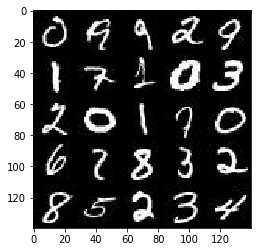

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

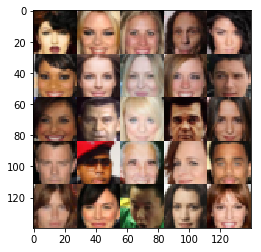

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_img_inputs = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name="real_img_inputs")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    lr = tf.placeholder(tf.float32, name="lr")
    
    return real_img_inputs,z_inputs,lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [120]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28xoutput_dim
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1*0.2)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*0.2)
        # 7x7x256
        
        # 4x4x512
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*0.2)
        
        # 2x2x1024
        x4 = tf.layers.conv2d(x3, 1024, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(x4, x4*0.2)
    
        # flatten
        x5 = tf.reshape(x4, (-1,2*2*1024))
        logits = tf.layers.dense(x5, 1)
        out = tf.sigmoid(logits)
        

    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [121]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z,2*2*512)
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        #print(x1.shape)
        
        # 7x7x256
        x2 = tf.layers.conv2d_transpose(x1,256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        #print(x2.shape)
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(x2,128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        #print(x3.shape)
        
        # 28x28xout
        x4 = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        #print(x4.shape)
        
        out = tf.tanh(x4)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [122]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # get the logits
    gen_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(images=gen_out, reuse=True)
    
    
    # loss calculations
    labels_real = tf.ones_like(d_out_real)
    labels_fake = tf.zeros_like(d_out_fake)
    labels_generator = tf.ones_like(d_out_fake)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_generator))
    

    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [123]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_trainable_vars = tf.trainable_variables()
    g_vars = [var for var in all_trainable_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_trainable_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [124]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [127]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    img_channels_count = data_shape[3]
    
    print("Image size ",img_width,"x",img_height,"x",img_channels_count)
    # build model 
    real_img_inputs, z_inputs, lr = model_inputs(img_width, img_height, img_channels_count, z_dim)
    d_loss, g_loss = model_loss(real_img_inputs, z_inputs, img_channels_count)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model

                # generate random noise 
                batch_z = np.random.uniform(-1,1, size=(batch_size,z_dim))
               
                # train discriminator and generator together
                _ = sess.run(d_train_opt, feed_dict={real_img_inputs:batch_images, z_inputs:batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                _ = sess.run(g_train_opt, feed_dict={z_inputs:batch_z, lr:learning_rate, real_img_inputs:batch_images})
                # now print loss every 100 iteration
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_inputs:batch_z,real_img_inputs:batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})
                    
                    print("Epoch ",epoch_i,
                          " ... Discri.Loss: ", train_loss_d, 
                          " Generator loss: ", train_loss_g )
                if steps % 100 == 0:    
                    show_generator_output(sess, 16, z_inputs, img_channels_count, data_image_mode)
        
        saver.save(sess, './saved_data.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Image size  28 x 28 x 1
Epoch  0  ... Discri.Loss:  0.235904  Generator loss:  2.25147
Epoch  0  ... Discri.Loss:  3.48232  Generator loss:  0.0330385
Epoch  0  ... Discri.Loss:  1.27448  Generator loss:  2.59226
Epoch  0  ... Discri.Loss:  0.918207  Generator loss:  0.629542
Epoch  0  ... Discri.Loss:  0.392511  Generator loss:  3.10464
Epoch  0  ... Discri.Loss:  0.995649  Generator loss:  0.941936
Epoch  0  ... Discri.Loss:  0.363091  Generator loss:  4.12631
Epoch  0  ... Discri.Loss:  0.592727  Generator loss:  3.11011
Epoch  0  ... Discri.Loss:  1.57751  Generator loss:  0.410832
Epoch  0  ... Discri.Loss:  1.70645  Generator loss:  0.640779


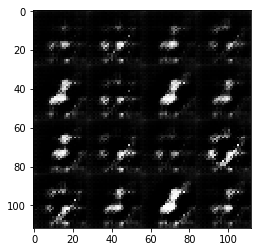

Epoch  0  ... Discri.Loss:  0.525206  Generator loss:  3.5536
Epoch  0  ... Discri.Loss:  0.702456  Generator loss:  1.22145
Epoch  0  ... Discri.Loss:  1.02176  Generator loss:  0.669868
Epoch  0  ... Discri.Loss:  0.251738  Generator loss:  2.34776
Epoch  0  ... Discri.Loss:  0.414485  Generator loss:  2.10137
Epoch  0  ... Discri.Loss:  1.24524  Generator loss:  0.524666
Epoch  0  ... Discri.Loss:  0.518779  Generator loss:  1.22303
Epoch  0  ... Discri.Loss:  0.701465  Generator loss:  0.809875
Epoch  0  ... Discri.Loss:  0.407864  Generator loss:  1.32937
Epoch  0  ... Discri.Loss:  4.17287  Generator loss:  9.9207


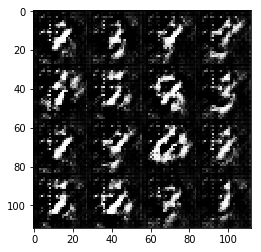

Epoch  0  ... Discri.Loss:  0.152547  Generator loss:  2.67248
Epoch  0  ... Discri.Loss:  0.793092  Generator loss:  0.666311
Epoch  0  ... Discri.Loss:  0.91037  Generator loss:  2.05066
Epoch  0  ... Discri.Loss:  1.24511  Generator loss:  1.40491
Epoch  0  ... Discri.Loss:  1.26562  Generator loss:  0.894242
Epoch  0  ... Discri.Loss:  0.733176  Generator loss:  1.05718
Epoch  0  ... Discri.Loss:  0.792809  Generator loss:  1.02251
Epoch  0  ... Discri.Loss:  0.554587  Generator loss:  2.02201
Epoch  0  ... Discri.Loss:  0.679498  Generator loss:  0.912857
Epoch  0  ... Discri.Loss:  0.953404  Generator loss:  4.96264


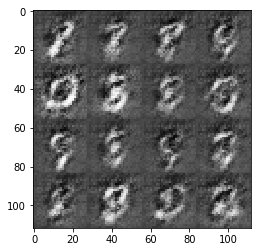

Epoch  0  ... Discri.Loss:  0.624382  Generator loss:  1.11765
Epoch  0  ... Discri.Loss:  0.511932  Generator loss:  1.06747
Epoch  0  ... Discri.Loss:  0.335531  Generator loss:  1.61556
Epoch  0  ... Discri.Loss:  0.980664  Generator loss:  0.700154
Epoch  0  ... Discri.Loss:  0.825807  Generator loss:  0.857207
Epoch  0  ... Discri.Loss:  0.594871  Generator loss:  1.02636
Epoch  0  ... Discri.Loss:  0.261357  Generator loss:  2.55828
Epoch  0  ... Discri.Loss:  0.623307  Generator loss:  0.91979
Epoch  0  ... Discri.Loss:  1.04165  Generator loss:  0.523267
Epoch  0  ... Discri.Loss:  1.29603  Generator loss:  1.38306


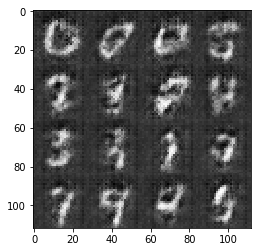

Epoch  0  ... Discri.Loss:  1.2672  Generator loss:  0.64886
Epoch  0  ... Discri.Loss:  1.09454  Generator loss:  0.754839
Epoch  0  ... Discri.Loss:  0.936387  Generator loss:  1.05548
Epoch  0  ... Discri.Loss:  0.982819  Generator loss:  0.82125
Epoch  0  ... Discri.Loss:  0.678164  Generator loss:  1.18042
Epoch  0  ... Discri.Loss:  0.625007  Generator loss:  2.27371
Epoch  1  ... Discri.Loss:  0.464613  Generator loss:  1.26579
Epoch  1  ... Discri.Loss:  0.42663  Generator loss:  1.5567
Epoch  1  ... Discri.Loss:  0.570128  Generator loss:  0.993168
Epoch  1  ... Discri.Loss:  0.403799  Generator loss:  1.26249


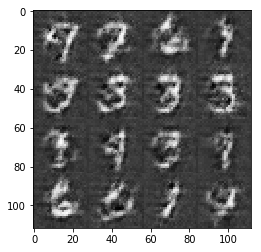

Epoch  1  ... Discri.Loss:  0.288748  Generator loss:  4.20778
Epoch  1  ... Discri.Loss:  0.43281  Generator loss:  1.18466
Epoch  1  ... Discri.Loss:  0.0808135  Generator loss:  3.34551
Epoch  1  ... Discri.Loss:  0.0655774  Generator loss:  3.3985
Epoch  1  ... Discri.Loss:  0.934879  Generator loss:  0.687331
Epoch  1  ... Discri.Loss:  0.340562  Generator loss:  1.95305
Epoch  1  ... Discri.Loss:  0.870576  Generator loss:  0.644867
Epoch  1  ... Discri.Loss:  0.217226  Generator loss:  1.9821
Epoch  1  ... Discri.Loss:  0.0644745  Generator loss:  3.21552
Epoch  1  ... Discri.Loss:  0.0596411  Generator loss:  3.32347


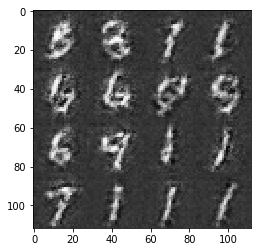

Epoch  1  ... Discri.Loss:  0.0594092  Generator loss:  3.40819
Epoch  1  ... Discri.Loss:  1.17717  Generator loss:  1.90362
Epoch  1  ... Discri.Loss:  0.913463  Generator loss:  1.20592
Epoch  1  ... Discri.Loss:  0.577161  Generator loss:  1.06616
Epoch  1  ... Discri.Loss:  0.382457  Generator loss:  1.39532
Epoch  1  ... Discri.Loss:  0.802171  Generator loss:  0.774219
Epoch  1  ... Discri.Loss:  0.401938  Generator loss:  1.3556
Epoch  1  ... Discri.Loss:  0.0275111  Generator loss:  4.91321
Epoch  1  ... Discri.Loss:  0.0493599  Generator loss:  3.60901
Epoch  1  ... Discri.Loss:  0.0655813  Generator loss:  3.26912


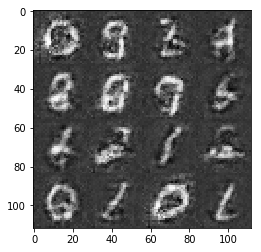

Epoch  1  ... Discri.Loss:  0.0134256  Generator loss:  7.06895
Epoch  1  ... Discri.Loss:  0.0176581  Generator loss:  5.66455
Epoch  1  ... Discri.Loss:  0.0604865  Generator loss:  3.26969
Epoch  1  ... Discri.Loss:  0.0166856  Generator loss:  5.08573
Epoch  1  ... Discri.Loss:  0.0162039  Generator loss:  5.38473
Epoch  1  ... Discri.Loss:  5.53429  Generator loss:  6.5785
Epoch  1  ... Discri.Loss:  0.985636  Generator loss:  1.02173
Epoch  1  ... Discri.Loss:  1.03931  Generator loss:  1.3507
Epoch  1  ... Discri.Loss:  0.545252  Generator loss:  1.74213
Epoch  1  ... Discri.Loss:  0.577467  Generator loss:  2.97755


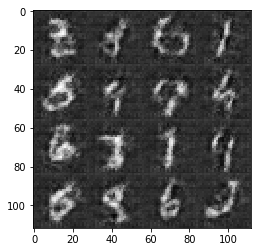

Epoch  1  ... Discri.Loss:  1.28341  Generator loss:  0.403853
Epoch  1  ... Discri.Loss:  0.387451  Generator loss:  2.03628
Epoch  1  ... Discri.Loss:  0.399416  Generator loss:  3.99581
Epoch  1  ... Discri.Loss:  0.445421  Generator loss:  1.90473
Epoch  1  ... Discri.Loss:  0.0907443  Generator loss:  3.2628
Epoch  1  ... Discri.Loss:  0.438  Generator loss:  1.23745
Epoch  1  ... Discri.Loss:  0.649531  Generator loss:  0.879017
Epoch  1  ... Discri.Loss:  0.0721239  Generator loss:  3.12786
Epoch  1  ... Discri.Loss:  12.1187  Generator loss:  10.2226
Epoch  1  ... Discri.Loss:  1.14131  Generator loss:  0.824727


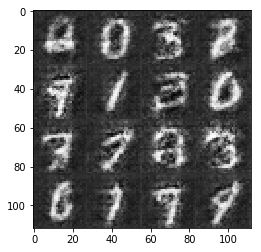

Epoch  1  ... Discri.Loss:  0.983279  Generator loss:  1.02197
Epoch  1  ... Discri.Loss:  1.15658  Generator loss:  0.831446
Epoch  1  ... Discri.Loss:  1.2174  Generator loss:  0.59085


In [128]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Image size  28 x 28 x 3
Epoch  0  ... Discri.Loss:  0.165058  Generator loss:  11.561
Epoch  0  ... Discri.Loss:  2.60847  Generator loss:  0.084608
Epoch  0  ... Discri.Loss:  0.374032  Generator loss:  2.18243
Epoch  0  ... Discri.Loss:  1.86096  Generator loss:  1.89095
Epoch  0  ... Discri.Loss:  1.10877  Generator loss:  0.459238
Epoch  0  ... Discri.Loss:  0.545221  Generator loss:  2.51431
Epoch  0  ... Discri.Loss:  1.80962  Generator loss:  2.92991
Epoch  0  ... Discri.Loss:  1.22553  Generator loss:  1.66529
Epoch  0  ... Discri.Loss:  1.10968  Generator loss:  0.759476
Epoch  0  ... Discri.Loss:  0.883168  Generator loss:  2.12334


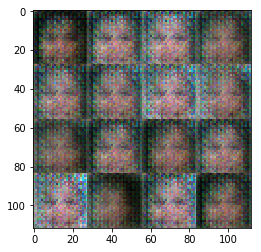

Epoch  0  ... Discri.Loss:  1.29291  Generator loss:  2.26442
Epoch  0  ... Discri.Loss:  1.73912  Generator loss:  0.8853
Epoch  0  ... Discri.Loss:  1.6297  Generator loss:  0.423306
Epoch  0  ... Discri.Loss:  1.59263  Generator loss:  0.583712
Epoch  0  ... Discri.Loss:  1.5931  Generator loss:  0.617848
Epoch  0  ... Discri.Loss:  1.61798  Generator loss:  0.703565
Epoch  0  ... Discri.Loss:  1.52179  Generator loss:  0.62877
Epoch  0  ... Discri.Loss:  1.21512  Generator loss:  0.723181
Epoch  0  ... Discri.Loss:  1.50293  Generator loss:  0.679297
Epoch  0  ... Discri.Loss:  1.56616  Generator loss:  0.674377


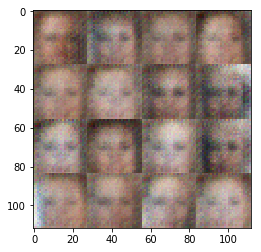

Epoch  0  ... Discri.Loss:  1.36183  Generator loss:  0.739197
Epoch  0  ... Discri.Loss:  1.27729  Generator loss:  0.604891
Epoch  0  ... Discri.Loss:  1.41293  Generator loss:  0.540856
Epoch  0  ... Discri.Loss:  1.54069  Generator loss:  0.469714
Epoch  0  ... Discri.Loss:  1.32126  Generator loss:  0.941059
Epoch  0  ... Discri.Loss:  1.44032  Generator loss:  0.716073
Epoch  0  ... Discri.Loss:  1.36366  Generator loss:  0.695537
Epoch  0  ... Discri.Loss:  1.51128  Generator loss:  0.694393
Epoch  0  ... Discri.Loss:  1.2769  Generator loss:  0.529391
Epoch  0  ... Discri.Loss:  1.31177  Generator loss:  0.596541


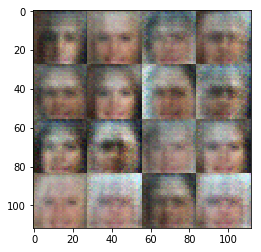

Epoch  0  ... Discri.Loss:  1.47751  Generator loss:  0.504286
Epoch  0  ... Discri.Loss:  1.66512  Generator loss:  0.302652
Epoch  0  ... Discri.Loss:  1.34188  Generator loss:  0.660821
Epoch  0  ... Discri.Loss:  1.394  Generator loss:  0.578388
Epoch  0  ... Discri.Loss:  1.31851  Generator loss:  0.627765
Epoch  0  ... Discri.Loss:  1.39794  Generator loss:  0.734676
Epoch  0  ... Discri.Loss:  1.25228  Generator loss:  0.732464
Epoch  0  ... Discri.Loss:  1.29397  Generator loss:  0.87574
Epoch  0  ... Discri.Loss:  1.35836  Generator loss:  0.557038
Epoch  0  ... Discri.Loss:  1.36249  Generator loss:  0.81021


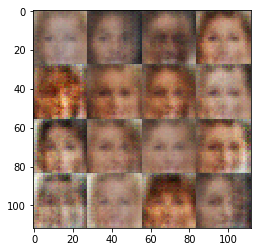

Epoch  0  ... Discri.Loss:  1.20489  Generator loss:  0.75263
Epoch  0  ... Discri.Loss:  1.28514  Generator loss:  0.612693
Epoch  0  ... Discri.Loss:  1.17407  Generator loss:  0.930082
Epoch  0  ... Discri.Loss:  1.26307  Generator loss:  0.731764
Epoch  0  ... Discri.Loss:  1.21976  Generator loss:  0.731243
Epoch  0  ... Discri.Loss:  1.32128  Generator loss:  0.71368
Epoch  0  ... Discri.Loss:  1.23925  Generator loss:  0.599626
Epoch  0  ... Discri.Loss:  1.43089  Generator loss:  0.562946
Epoch  0  ... Discri.Loss:  1.26451  Generator loss:  1.78423
Epoch  0  ... Discri.Loss:  1.21101  Generator loss:  0.907314


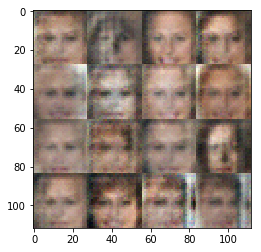

Epoch  0  ... Discri.Loss:  1.48804  Generator loss:  0.357109
Epoch  0  ... Discri.Loss:  1.297  Generator loss:  0.793049
Epoch  0  ... Discri.Loss:  1.05724  Generator loss:  0.778708
Epoch  0  ... Discri.Loss:  1.09393  Generator loss:  0.755726
Epoch  0  ... Discri.Loss:  1.41677  Generator loss:  0.446692
Epoch  0  ... Discri.Loss:  1.53218  Generator loss:  0.325297
Epoch  0  ... Discri.Loss:  1.37558  Generator loss:  0.557779
Epoch  0  ... Discri.Loss:  1.39957  Generator loss:  0.357319
Epoch  0  ... Discri.Loss:  1.07328  Generator loss:  0.867892
Epoch  0  ... Discri.Loss:  1.10815  Generator loss:  0.781903


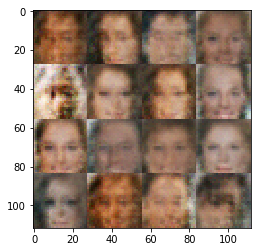

Epoch  0  ... Discri.Loss:  1.29406  Generator loss:  0.673283
Epoch  0  ... Discri.Loss:  1.26784  Generator loss:  0.707684
Epoch  0  ... Discri.Loss:  1.46731  Generator loss:  0.388306
Epoch  0  ... Discri.Loss:  1.31859  Generator loss:  0.623218
Epoch  0  ... Discri.Loss:  1.51624  Generator loss:  0.306893
Epoch  0  ... Discri.Loss:  1.07342  Generator loss:  0.602197
Epoch  0  ... Discri.Loss:  1.20703  Generator loss:  0.796528
Epoch  0  ... Discri.Loss:  1.25127  Generator loss:  0.518682
Epoch  0  ... Discri.Loss:  1.53129  Generator loss:  0.310008
Epoch  0  ... Discri.Loss:  1.53446  Generator loss:  2.17761


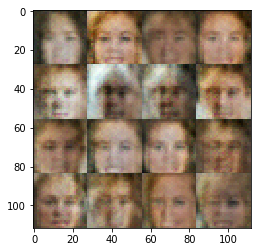

Epoch  0  ... Discri.Loss:  1.19025  Generator loss:  0.520136
Epoch  0  ... Discri.Loss:  1.38599  Generator loss:  0.88615
Epoch  0  ... Discri.Loss:  1.51837  Generator loss:  0.432812
Epoch  0  ... Discri.Loss:  1.05358  Generator loss:  1.38929
Epoch  0  ... Discri.Loss:  1.16781  Generator loss:  0.663016
Epoch  0  ... Discri.Loss:  1.14969  Generator loss:  1.13968
Epoch  0  ... Discri.Loss:  0.802922  Generator loss:  1.40565
Epoch  0  ... Discri.Loss:  0.93061  Generator loss:  1.12611
Epoch  0  ... Discri.Loss:  1.308  Generator loss:  1.19605
Epoch  0  ... Discri.Loss:  1.16707  Generator loss:  0.639276


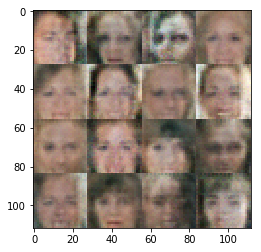

Epoch  0  ... Discri.Loss:  1.03313  Generator loss:  2.53037
Epoch  0  ... Discri.Loss:  1.05911  Generator loss:  0.971074
Epoch  0  ... Discri.Loss:  1.11603  Generator loss:  0.600119
Epoch  0  ... Discri.Loss:  0.951817  Generator loss:  0.865239
Epoch  0  ... Discri.Loss:  1.06547  Generator loss:  1.03142
Epoch  0  ... Discri.Loss:  0.845089  Generator loss:  1.81321
Epoch  0  ... Discri.Loss:  1.38021  Generator loss:  0.435189
Epoch  0  ... Discri.Loss:  0.78463  Generator loss:  2.02526
Epoch  0  ... Discri.Loss:  0.84708  Generator loss:  0.823962
Epoch  0  ... Discri.Loss:  1.23583  Generator loss:  0.550521


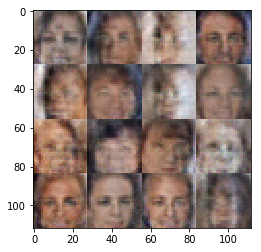

Epoch  0  ... Discri.Loss:  1.32076  Generator loss:  0.424557
Epoch  0  ... Discri.Loss:  1.01204  Generator loss:  0.622626
Epoch  0  ... Discri.Loss:  1.27418  Generator loss:  0.622029
Epoch  0  ... Discri.Loss:  0.773988  Generator loss:  1.06339
Epoch  0  ... Discri.Loss:  1.3555  Generator loss:  0.475667
Epoch  0  ... Discri.Loss:  0.821709  Generator loss:  1.0014
Epoch  0  ... Discri.Loss:  0.796843  Generator loss:  0.760523
Epoch  0  ... Discri.Loss:  1.44743  Generator loss:  0.359571
Epoch  0  ... Discri.Loss:  1.208  Generator loss:  0.565446
Epoch  0  ... Discri.Loss:  1.44137  Generator loss:  0.738201


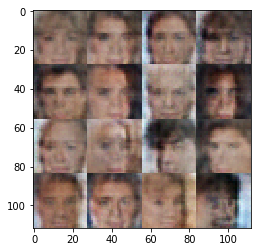

Epoch  0  ... Discri.Loss:  1.40276  Generator loss:  0.404936
Epoch  0  ... Discri.Loss:  0.833322  Generator loss:  1.3744
Epoch  0  ... Discri.Loss:  1.36455  Generator loss:  0.464771
Epoch  0  ... Discri.Loss:  1.18715  Generator loss:  0.461735
Epoch  0  ... Discri.Loss:  0.880563  Generator loss:  1.50471
Epoch  0  ... Discri.Loss:  1.39718  Generator loss:  0.343381
Epoch  0  ... Discri.Loss:  0.98617  Generator loss:  1.22978
Epoch  0  ... Discri.Loss:  0.998893  Generator loss:  0.733281
Epoch  0  ... Discri.Loss:  1.78081  Generator loss:  0.22813
Epoch  0  ... Discri.Loss:  0.580675  Generator loss:  1.82785


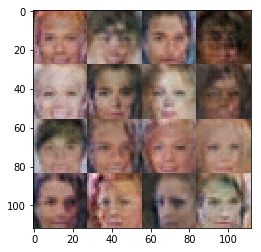

Epoch  0  ... Discri.Loss:  0.805404  Generator loss:  0.768474
Epoch  0  ... Discri.Loss:  2.90233  Generator loss:  0.0658661
Epoch  0  ... Discri.Loss:  1.25978  Generator loss:  0.414711
Epoch  0  ... Discri.Loss:  0.0496352  Generator loss:  3.63802
Epoch  0  ... Discri.Loss:  2.05102  Generator loss:  0.166131
Epoch  0  ... Discri.Loss:  0.604888  Generator loss:  1.27427
Epoch  0  ... Discri.Loss:  2.31362  Generator loss:  0.121175
Epoch  0  ... Discri.Loss:  1.13215  Generator loss:  0.493975
Epoch  0  ... Discri.Loss:  0.601983  Generator loss:  1.41352
Epoch  0  ... Discri.Loss:  0.786409  Generator loss:  1.16856


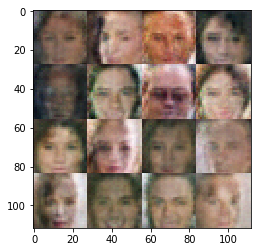

Epoch  0  ... Discri.Loss:  0.263597  Generator loss:  3.06336
Epoch  0  ... Discri.Loss:  0.252271  Generator loss:  1.99803
Epoch  0  ... Discri.Loss:  0.0344559  Generator loss:  4.60815
Epoch  0  ... Discri.Loss:  1.63945  Generator loss:  5.68115
Epoch  0  ... Discri.Loss:  1.32098  Generator loss:  0.862359
Epoch  0  ... Discri.Loss:  1.65214  Generator loss:  0.649352
Epoch  0  ... Discri.Loss:  1.5358  Generator loss:  0.721935
Epoch  0  ... Discri.Loss:  1.42564  Generator loss:  0.682791
Epoch  0  ... Discri.Loss:  1.40158  Generator loss:  0.699034
Epoch  0  ... Discri.Loss:  1.41726  Generator loss:  0.647044


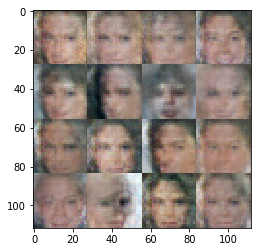

Epoch  0  ... Discri.Loss:  1.28519  Generator loss:  0.729215
Epoch  0  ... Discri.Loss:  1.23182  Generator loss:  0.721243
Epoch  0  ... Discri.Loss:  1.18003  Generator loss:  0.712607
Epoch  0  ... Discri.Loss:  1.10259  Generator loss:  0.750085
Epoch  0  ... Discri.Loss:  1.25637  Generator loss:  0.698431
Epoch  0  ... Discri.Loss:  2.0412  Generator loss:  0.173508
Epoch  0  ... Discri.Loss:  1.15234  Generator loss:  0.798134
Epoch  0  ... Discri.Loss:  0.964863  Generator loss:  0.660678
Epoch  0  ... Discri.Loss:  1.25044  Generator loss:  0.439815
Epoch  0  ... Discri.Loss:  0.203034  Generator loss:  3.53725


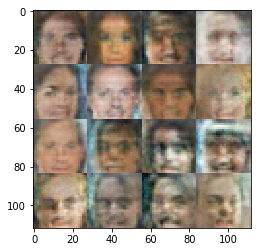

Epoch  0  ... Discri.Loss:  1.4484  Generator loss:  0.301391
Epoch  0  ... Discri.Loss:  0.840011  Generator loss:  0.716652
Epoch  0  ... Discri.Loss:  0.326376  Generator loss:  1.64512
Epoch  0  ... Discri.Loss:  1.46512  Generator loss:  0.407801
Epoch  0  ... Discri.Loss:  1.31973  Generator loss:  0.5159
Epoch  0  ... Discri.Loss:  0.503829  Generator loss:  1.7631
Epoch  0  ... Discri.Loss:  0.187507  Generator loss:  3.77697


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.